# Project: Dog vs Cat Classification

In [485]:
from pathlib import Path
import os
import torch
from torch import nn

In [486]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [487]:
data_path = Path("data/")
train_path = data_path / "train"
test_path = data_path / "test"

train_path, test_path

(WindowsPath('data/train'), WindowsPath('data/test'))

In [488]:
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 1.0, 'Dog, Shape: (457, 500, 3)')

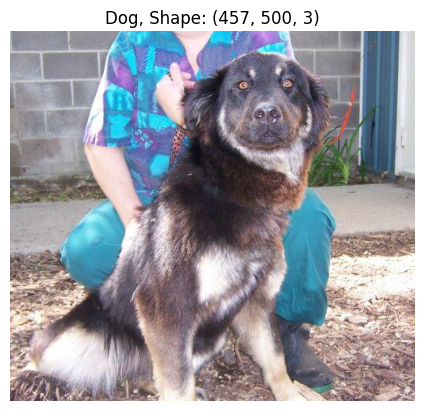

In [489]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
image_path_list = list(data_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
img_is_array = np.asarray(img)

plt.imshow(img)
plt.axis(False)
plt.title(f"{image_class}, Shape: {img_is_array.shape}")

In [490]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [491]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [492]:
transformed_image = data_transform(img)
transformed_image

tensor([[[0.5765, 0.5490, 0.5608,  ..., 0.5608, 0.8784, 0.8392],
         [0.5686, 0.5412, 0.5608,  ..., 0.5804, 0.8902, 0.8431],
         [0.5843, 0.5569, 0.5725,  ..., 0.6000, 0.8941, 0.8431],
         ...,
         [0.6392, 0.5882, 0.5765,  ..., 0.6706, 0.6902, 0.6157],
         [0.4588, 0.5255, 0.6078,  ..., 0.7373, 0.7294, 0.6980],
         [0.4078, 0.5255, 0.5765,  ..., 0.6863, 0.6902, 0.6980]],

        [[0.5765, 0.5451, 0.5608,  ..., 0.6235, 0.8784, 0.8431],
         [0.5804, 0.5451, 0.5608,  ..., 0.6431, 0.8902, 0.8431],
         [0.6000, 0.5647, 0.5804,  ..., 0.6588, 0.8941, 0.8471],
         ...,
         [0.5137, 0.4745, 0.4706,  ..., 0.5647, 0.6078, 0.5333],
         [0.3647, 0.4235, 0.4902,  ..., 0.6431, 0.6627, 0.6157],
         [0.3216, 0.4235, 0.4627,  ..., 0.5882, 0.6000, 0.6078]],

        [[0.5922, 0.5922, 0.6078,  ..., 0.6667, 0.9020, 0.8471],
         [0.6039, 0.5961, 0.6078,  ..., 0.6863, 0.9137, 0.8471],
         [0.6275, 0.6235, 0.6314,  ..., 0.6941, 0.9216, 0.

Text(0.5, 1.0, 'Dog, Shape: torch.Size([3, 64, 64])')

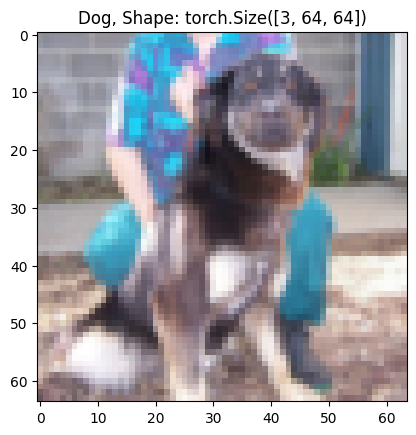

In [493]:
plt.imshow(transformed_image.permute(1, 2, 0))
plt.title(f"{image_class}, Shape: {transformed_image.shape}")

# Loading data using 'ImageFolder'

In [494]:
train_data = datasets.ImageFolder(root=train_path,
                                  transform=data_transform)

test_data = datasets.ImageFolder(root=test_path,
                                 transform=test_data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 160
     Root location: data\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 42
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [495]:
# Get class names as list
class_names = train_data.classes
class_names

['Cat', 'Dog']

In [496]:
# Get class names as dictionary 
class_dict = train_data.class_to_idx
class_dict

{'Cat': 0, 'Dog': 1}

In [497]:
len(train_data), len(test_data)

(160, 42)

# Turn loaded images into 'DataLoader'

In [498]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1c1ee3eb4c0>,
 <torch.utils.data.dataloader.DataLoader at 0x1c1f51b20a0>)

In [499]:
img_custom, label_custom = next(iter(train_dataloader))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [500]:
class DogVsCat(nn.Module):
    def __init__(self, input_shape, hidden_layers, output_shape):
        super().__init__()

        self.conv_block_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_layers,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_layers,
                      out_channels=hidden_layers,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.conv_block_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_layers,
                      out_channels=hidden_layers,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_layers,
                      out_channels=hidden_layers,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.classification = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_layers*16*16,
                      out_features=output_shape)
        )

    def forward(self, x):
        #print(f"Shape: {x.shape}")
        x = self.conv_block_layer_1(x)
        #print(f"Shape: {x.shape}")
        x = self.conv_block_layer_2(x)
        #print(f"Shape: {x.shape}")
        x = self.classification(x)
        #print(f"Shape: {x.shape}")
        return x
        

In [501]:
model_0 = DogVsCat(input_shape=3, hidden_layers=16, output_shape=1).to(device)
model_0

DogVsCat(
  (conv_block_layer_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_layer_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=1, bias=True)
  )
)

In [502]:
# Setup loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

loss_fn, optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [503]:
# Check the correct shape on dummy tensor
dummy_input = torch.randn(32, 3, 64, 64)
output = model_0(dummy_input.to(device))
output

tensor([[-0.0251],
        [-0.0411],
        [-0.0281],
        [-0.0197],
        [-0.0339],
        [-0.0396],
        [-0.0399],
        [-0.0231],
        [-0.0398],
        [-0.0292],
        [-0.0458],
        [-0.0372],
        [-0.0230],
        [-0.0245],
        [-0.0388],
        [-0.0403],
        [-0.0344],
        [-0.0413],
        [-0.0282],
        [-0.0536],
        [-0.0320],
        [-0.0313],
        [-0.0250],
        [-0.0288],
        [-0.0329],
        [-0.0346],
        [-0.0407],
        [-0.0111],
        [-0.0278],
        [-0.0263],
        [-0.0261],
        [-0.0253]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [504]:
from tqdm import tqdm
import time

In [505]:
epochs = 5

start_time = time.time()

results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

for epoch in tqdm(range(epochs)):

    model_0.train()
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        y = y.unsqueeze(dim=1).float()
        
        y_pred = model_0(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
        train_acc += (y_pred_class==y).sum().item() / len(y_pred)

    train_loss /= len(train_dataloader)
    train_acc = (train_acc / len(train_dataloader)) * 100
    
    model_0.eval()
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            X, y = X.to(device), y.to(device)

            y = y.unsqueeze(dim=1).float()
        
            test_pred = model_0(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = (torch.sigmoid(test_pred) > 0.5).float()
            test_acc += (test_pred_class==y).sum().item() / len(test_pred)
    
        test_loss /= len(test_dataloader)
        test_acc = (test_acc / len(test_dataloader)) * 100

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss}, Test Accuracy: {test_acc}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    


end_time = time.time()
train_time = end_time - start_time

print(f"Total time: {train_time}")

 20%|██        | 1/5 [00:00<00:02,  1.86it/s]

Epoch: 0 | Train Loss: 0.6941, Train Accuracy: 50.00 | Test Loss: 0.6896839141845703, Test Accuracy: 67.1875


 40%|████      | 2/5 [00:01<00:01,  1.80it/s]

Epoch: 1 | Train Loss: 0.6980, Train Accuracy: 50.00 | Test Loss: 0.668611466884613, Test Accuracy: 67.1875


 60%|██████    | 3/5 [00:01<00:01,  1.98it/s]

Epoch: 2 | Train Loss: 0.6980, Train Accuracy: 50.62 | Test Loss: 0.6912986934185028, Test Accuracy: 65.3125


 80%|████████  | 4/5 [00:01<00:00,  2.08it/s]

Epoch: 3 | Train Loss: 0.6921, Train Accuracy: 56.88 | Test Loss: 0.6930177509784698, Test Accuracy: 60.0


100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

Epoch: 4 | Train Loss: 0.6920, Train Accuracy: 56.88 | Test Loss: 0.6941890120506287, Test Accuracy: 44.375
Total time: 2.4450016021728516


# Plot model_0 results

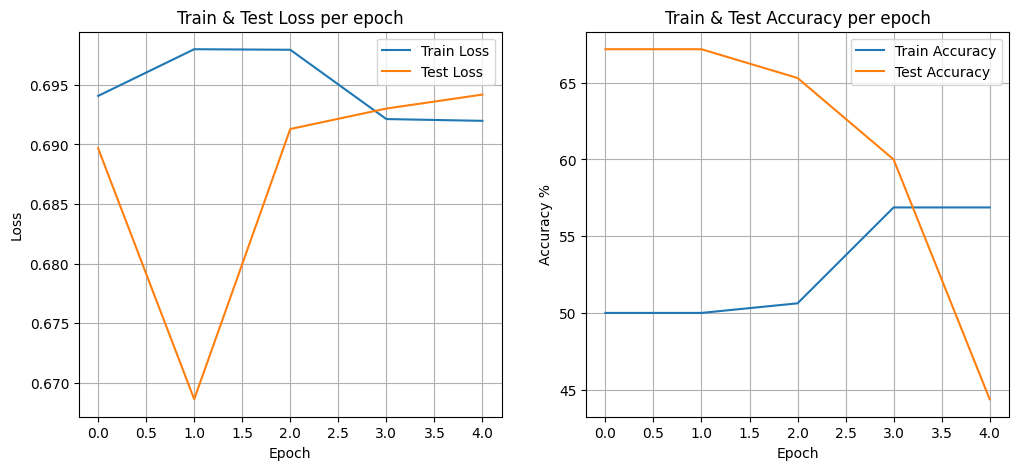

In [506]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_loss"], label="Train Loss")
plt.plot(range(epochs), results["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss per epoch")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), results["train_acc"], label="Train Accuracy")
plt.plot(range(epochs), results["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.title("Train & Test Accuracy per epoch")
plt.legend()
plt.grid()



In [507]:
print(len(results["train_loss"]), len(results["test_loss"]))
print(len(results["train_acc"]), len(results["test_acc"]))

5 5
5 5


In [508]:
# Build train and test function to make training easier
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim,
               device=device):

    train_loss, correct_preds, total_samples = 0, 0, 0
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y = y.unsqueeze(dim=1).float()
        
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
        y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
        #train_acc += (y_pred_class==y).sum().item() / len(y_pred)
        correct_preds += (y_pred_class == y).sum().item()
        total_samples += y.size(0)

    train_loss /= len(dataloader)
    #train_acc = (train_acc / len(dataloader)) * 100
    train_acc = (correct_preds / total_samples) * 100
    
    return train_loss, train_acc

In [509]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):

    test_loss, correct_preds, total_samples = 0, 0, 0
    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            y = y.unsqueeze(dim=1).float()
        
            test_pred = model(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = (torch.sigmoid(test_pred) > 0.5).float()
            #test_acc += (test_pred_class==y).sum().item() / len(test_pred)
            correct_preds += (test_pred_class == y).sum().item()
            total_samples += y.size(0)
    
    test_loss /= len(dataloader)
    #test_acc = (test_acc / len(dataloader)) * 100
    test_acc = (correct_preds / total_samples) * 100
    return test_loss, test_acc

# Augmentation data

In [510]:
train_data_transform_augmentation = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # used to differentiate the data
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_data = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
train_data_transform_augmentation, test_data

(Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
     RandomHorizontalFlip(p=0.5)
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ),
 Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ))

In [511]:
train_data_augmentation = datasets.ImageFolder(root=train_path,
                                               transform=train_data_transform_augmentation)
test_data_augmentation = datasets.ImageFolder(root=test_path,
                                              transform=test_data)

train_data_augmentation, test_data_augmentation

(Dataset ImageFolder
     Number of datapoints: 160
     Root location: data\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ),
 Dataset ImageFolder
     Number of datapoints: 42
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ))

In [512]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader_augmentation = DataLoader(dataset=train_data_augmentation,
                                           batch_size=BATCH_SIZE,
                                           num_workers=NUM_WORKERS,
                                           shuffle=True)

test_dataloader_augmentation = DataLoader(dataset=test_data_augmentation,
                                          batch_size=BATCH_SIZE,
                                          num_workers=NUM_WORKERS,
                                          shuffle=False)

train_dataloader_augmentation, test_dataloader_augmentation

(<torch.utils.data.dataloader.DataLoader at 0x1c1f7fbf790>,
 <torch.utils.data.dataloader.DataLoader at 0x1c1f7fbf280>)

In [513]:
len(class_names)

2

In [514]:
model_1 = DogVsCat(input_shape=3, hidden_layers=16, output_shape=1).to(device)
model_1

DogVsCat(
  (conv_block_layer_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_layer_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=1, bias=True)
  )
)

In [515]:
# Setup loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

loss_fn, optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [516]:
# Train model_1 on augmentation data
epochs = 50

start_time = time.time()

results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

for epoch in tqdm(range(epochs)):

    train_loss, train_acc = train_step(model=model_1,
               dataloader=train_dataloader_augmentation,
               loss_fn=loss_fn,
               optimizer=optimizer)

    test_loss, test_acc = test_step(model=model_1,
              dataloader=test_dataloader_augmentation,
              loss_fn=loss_fn)

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss}, Test Accuracy: {test_acc}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    


end_time = time.time()
train_time = end_time - start_time

print(f"Total time: {train_time}")

  2%|▏         | 1/50 [00:00<00:25,  1.91it/s]

Epoch: 0 | Train Loss: 0.7016, Train Accuracy: 50.00 | Test Loss: 0.6744088530540466, Test Accuracy: 50.0


  4%|▍         | 2/50 [00:01<00:25,  1.88it/s]

Epoch: 1 | Train Loss: 0.6923, Train Accuracy: 50.00 | Test Loss: 0.6911297142505646, Test Accuracy: 50.0


  6%|▌         | 3/50 [00:01<00:24,  1.90it/s]

Epoch: 2 | Train Loss: 0.6932, Train Accuracy: 48.75 | Test Loss: 0.6996942758560181, Test Accuracy: 50.0


  8%|▊         | 4/50 [00:02<00:23,  1.93it/s]

Epoch: 3 | Train Loss: 0.6934, Train Accuracy: 50.00 | Test Loss: 0.7015315890312195, Test Accuracy: 50.0


 10%|█         | 5/50 [00:02<00:23,  1.93it/s]

Epoch: 4 | Train Loss: 0.6936, Train Accuracy: 50.00 | Test Loss: 0.6957567036151886, Test Accuracy: 50.0


 12%|█▏        | 6/50 [00:03<00:22,  1.92it/s]

Epoch: 5 | Train Loss: 0.6925, Train Accuracy: 51.25 | Test Loss: 0.6937506794929504, Test Accuracy: 59.523809523809526


 14%|█▍        | 7/50 [00:03<00:23,  1.81it/s]

Epoch: 6 | Train Loss: 0.6920, Train Accuracy: 58.13 | Test Loss: 0.6934493184089661, Test Accuracy: 57.14285714285714


 16%|█▌        | 8/50 [00:04<00:21,  1.92it/s]

Epoch: 7 | Train Loss: 0.6919, Train Accuracy: 53.75 | Test Loss: 0.6916148066520691, Test Accuracy: 61.904761904761905


 18%|█▊        | 9/50 [00:04<00:20,  2.03it/s]

Epoch: 8 | Train Loss: 0.6905, Train Accuracy: 56.88 | Test Loss: 0.6881726086139679, Test Accuracy: 57.14285714285714


 20%|██        | 10/50 [00:05<00:18,  2.12it/s]

Epoch: 9 | Train Loss: 0.6871, Train Accuracy: 59.38 | Test Loss: 0.6869917511940002, Test Accuracy: 64.28571428571429


 22%|██▏       | 11/50 [00:05<00:17,  2.20it/s]

Epoch: 10 | Train Loss: 0.6875, Train Accuracy: 56.88 | Test Loss: 0.6736157536506653, Test Accuracy: 64.28571428571429


 24%|██▍       | 12/50 [00:05<00:17,  2.13it/s]

Epoch: 11 | Train Loss: 0.6828, Train Accuracy: 58.13 | Test Loss: 0.6886040270328522, Test Accuracy: 66.66666666666666


 26%|██▌       | 13/50 [00:06<00:17,  2.08it/s]

Epoch: 12 | Train Loss: 0.6761, Train Accuracy: 55.00 | Test Loss: 0.6496504545211792, Test Accuracy: 59.523809523809526


 28%|██▊       | 14/50 [00:06<00:17,  2.04it/s]

Epoch: 13 | Train Loss: 0.6782, Train Accuracy: 56.25 | Test Loss: 0.6572052538394928, Test Accuracy: 61.904761904761905


 30%|███       | 15/50 [00:07<00:17,  2.02it/s]

Epoch: 14 | Train Loss: 0.6791, Train Accuracy: 55.00 | Test Loss: 0.6726396679878235, Test Accuracy: 59.523809523809526


 32%|███▏      | 16/50 [00:08<00:17,  1.99it/s]

Epoch: 15 | Train Loss: 0.6489, Train Accuracy: 62.50 | Test Loss: 0.6363379061222076, Test Accuracy: 57.14285714285714


 34%|███▍      | 17/50 [00:08<00:17,  1.90it/s]

Epoch: 16 | Train Loss: 0.6535, Train Accuracy: 61.88 | Test Loss: 0.6721825003623962, Test Accuracy: 61.904761904761905


 36%|███▌      | 18/50 [00:09<00:15,  2.01it/s]

Epoch: 17 | Train Loss: 0.6633, Train Accuracy: 63.75 | Test Loss: 0.7186688780784607, Test Accuracy: 64.28571428571429


 38%|███▊      | 19/50 [00:09<00:14,  2.10it/s]

Epoch: 18 | Train Loss: 0.6173, Train Accuracy: 66.88 | Test Loss: 0.6302686929702759, Test Accuracy: 64.28571428571429


 40%|████      | 20/50 [00:09<00:13,  2.16it/s]

Epoch: 19 | Train Loss: 0.6528, Train Accuracy: 64.38 | Test Loss: 0.6549461185932159, Test Accuracy: 61.904761904761905


 42%|████▏     | 21/50 [00:10<00:13,  2.17it/s]

Epoch: 20 | Train Loss: 0.6460, Train Accuracy: 61.88 | Test Loss: 0.6898180246353149, Test Accuracy: 66.66666666666666


 44%|████▍     | 22/50 [00:10<00:14,  1.96it/s]

Epoch: 21 | Train Loss: 0.6305, Train Accuracy: 65.62 | Test Loss: 0.6475070118904114, Test Accuracy: 66.66666666666666


 46%|████▌     | 23/50 [00:11<00:13,  2.07it/s]

Epoch: 22 | Train Loss: 0.6293, Train Accuracy: 67.50 | Test Loss: 0.6003485023975372, Test Accuracy: 66.66666666666666


 48%|████▊     | 24/50 [00:11<00:12,  2.15it/s]

Epoch: 23 | Train Loss: 0.6500, Train Accuracy: 60.00 | Test Loss: 0.6069664657115936, Test Accuracy: 66.66666666666666


 50%|█████     | 25/50 [00:12<00:11,  2.21it/s]

Epoch: 24 | Train Loss: 0.6358, Train Accuracy: 61.25 | Test Loss: 0.6407376229763031, Test Accuracy: 69.04761904761905


 52%|█████▏    | 26/50 [00:12<00:10,  2.24it/s]

Epoch: 25 | Train Loss: 0.6404, Train Accuracy: 64.38 | Test Loss: 0.5957538485527039, Test Accuracy: 64.28571428571429


 54%|█████▍    | 27/50 [00:13<00:10,  2.16it/s]

Epoch: 26 | Train Loss: 0.6381, Train Accuracy: 63.12 | Test Loss: 0.6077143549919128, Test Accuracy: 61.904761904761905


 56%|█████▌    | 28/50 [00:13<00:11,  1.99it/s]

Epoch: 27 | Train Loss: 0.6658, Train Accuracy: 55.62 | Test Loss: 0.568988099694252, Test Accuracy: 54.761904761904766


 58%|█████▊    | 29/50 [00:14<00:10,  2.09it/s]

Epoch: 28 | Train Loss: 0.6089, Train Accuracy: 61.88 | Test Loss: 0.5988481342792511, Test Accuracy: 66.66666666666666


 60%|██████    | 30/50 [00:14<00:09,  2.16it/s]

Epoch: 29 | Train Loss: 0.6365, Train Accuracy: 65.00 | Test Loss: 0.59829381108284, Test Accuracy: 66.66666666666666


 62%|██████▏   | 31/50 [00:15<00:08,  2.20it/s]

Epoch: 30 | Train Loss: 0.6221, Train Accuracy: 63.12 | Test Loss: 0.573663055896759, Test Accuracy: 61.904761904761905


 64%|██████▍   | 32/50 [00:15<00:08,  2.22it/s]

Epoch: 31 | Train Loss: 0.6171, Train Accuracy: 68.12 | Test Loss: 0.5713357925415039, Test Accuracy: 71.42857142857143


 66%|██████▌   | 33/50 [00:15<00:07,  2.18it/s]

Epoch: 32 | Train Loss: 0.6157, Train Accuracy: 66.25 | Test Loss: 0.5801638960838318, Test Accuracy: 73.80952380952381


 68%|██████▊   | 34/50 [00:16<00:07,  2.20it/s]

Epoch: 33 | Train Loss: 0.6116, Train Accuracy: 64.38 | Test Loss: 0.605326384305954, Test Accuracy: 71.42857142857143


 70%|███████   | 35/50 [00:16<00:07,  2.08it/s]

Epoch: 34 | Train Loss: 0.6079, Train Accuracy: 70.00 | Test Loss: 0.5573355406522751, Test Accuracy: 64.28571428571429


 72%|███████▏  | 36/50 [00:17<00:06,  2.14it/s]

Epoch: 35 | Train Loss: 0.6136, Train Accuracy: 66.25 | Test Loss: 0.6400609612464905, Test Accuracy: 66.66666666666666


 74%|███████▍  | 37/50 [00:17<00:06,  2.12it/s]

Epoch: 36 | Train Loss: 0.6017, Train Accuracy: 68.12 | Test Loss: 0.5490247756242752, Test Accuracy: 66.66666666666666


 76%|███████▌  | 38/50 [00:18<00:05,  2.06it/s]

Epoch: 37 | Train Loss: 0.5914, Train Accuracy: 66.88 | Test Loss: 0.6038239300251007, Test Accuracy: 66.66666666666666


 78%|███████▊  | 39/50 [00:19<00:05,  1.87it/s]

Epoch: 38 | Train Loss: 0.5479, Train Accuracy: 72.50 | Test Loss: 0.5716345459222794, Test Accuracy: 66.66666666666666


 80%|████████  | 40/50 [00:19<00:05,  1.99it/s]

Epoch: 39 | Train Loss: 0.5802, Train Accuracy: 67.50 | Test Loss: 0.5957124531269073, Test Accuracy: 69.04761904761905


 82%|████████▏ | 41/50 [00:19<00:04,  2.06it/s]

Epoch: 40 | Train Loss: 0.6564, Train Accuracy: 66.25 | Test Loss: 0.630787581205368, Test Accuracy: 66.66666666666666


 84%|████████▍ | 42/50 [00:20<00:03,  2.13it/s]

Epoch: 41 | Train Loss: 0.6532, Train Accuracy: 58.75 | Test Loss: 0.5781299024820328, Test Accuracy: 61.904761904761905


 86%|████████▌ | 43/50 [00:20<00:03,  2.20it/s]

Epoch: 42 | Train Loss: 0.6256, Train Accuracy: 65.62 | Test Loss: 0.6384927034378052, Test Accuracy: 66.66666666666666


 88%|████████▊ | 44/50 [00:21<00:02,  2.23it/s]

Epoch: 43 | Train Loss: 0.5940, Train Accuracy: 64.38 | Test Loss: 0.6205318570137024, Test Accuracy: 66.66666666666666


 90%|█████████ | 45/50 [00:21<00:02,  2.25it/s]

Epoch: 44 | Train Loss: 0.5854, Train Accuracy: 69.38 | Test Loss: 0.5995549559593201, Test Accuracy: 57.14285714285714


 92%|█████████▏| 46/50 [00:22<00:01,  2.06it/s]

Epoch: 45 | Train Loss: 0.5884, Train Accuracy: 68.75 | Test Loss: 0.6275163292884827, Test Accuracy: 64.28571428571429


 94%|█████████▍| 47/50 [00:22<00:01,  2.15it/s]

Epoch: 46 | Train Loss: 0.5974, Train Accuracy: 68.12 | Test Loss: 0.6324245631694794, Test Accuracy: 64.28571428571429


 96%|█████████▌| 48/50 [00:23<00:00,  2.22it/s]

Epoch: 47 | Train Loss: 0.5784, Train Accuracy: 66.88 | Test Loss: 0.5640821605920792, Test Accuracy: 61.904761904761905


 98%|█████████▊| 49/50 [00:23<00:00,  2.27it/s]

Epoch: 48 | Train Loss: 0.5724, Train Accuracy: 69.38 | Test Loss: 0.584673285484314, Test Accuracy: 59.523809523809526


100%|██████████| 50/50 [00:23<00:00,  2.09it/s]

Epoch: 49 | Train Loss: 0.5457, Train Accuracy: 72.50 | Test Loss: 0.6179700493812561, Test Accuracy: 64.28571428571429
Total time: 23.9023175239563


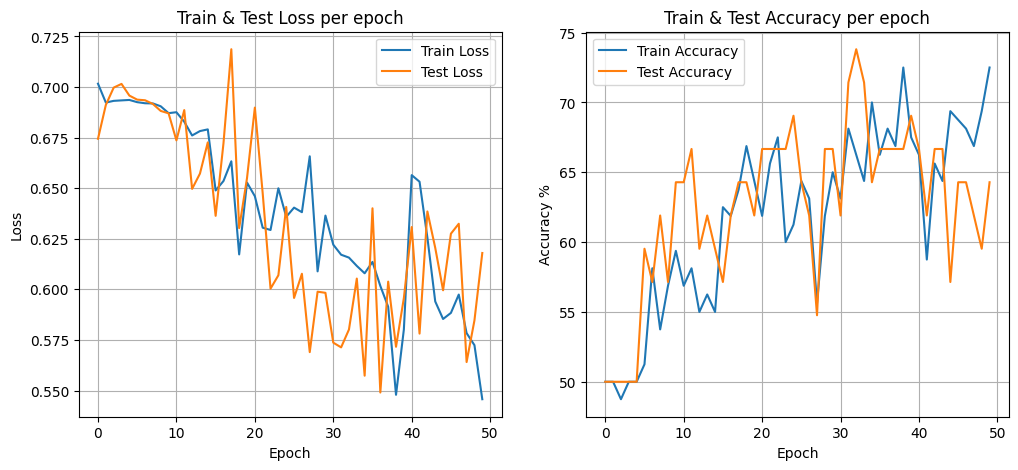

In [517]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_loss"], label="Train Loss")
plt.plot(range(epochs), results["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss per epoch")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), results["train_acc"], label="Train Accuracy")
plt.plot(range(epochs), results["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.title("Train & Test Accuracy per epoch")
plt.legend()
plt.grid()